# Decide on cell clusters to exclude

## Import statements

In [1]:
import scanpy as sc
import scanpy.external as sce
#sc.logging.print_versions()
#sc.logging.print_memory_usage()
#sc.settings.verbosity = 2
import os,sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker

#not all are used, I am just transfering this cell from notebook to notebook

In [2]:
# add the utility function folder to PATH
import sys
sys.path.append(os.path.abspath("utility_functions"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.8.8


## Load per-cell metadata (obs)

In [3]:

# overwrite obs with the most recent version
filename = 'backups/obs_info_scrub_20021x13_230928_16h03.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)


In [4]:
obs.keys()

Index(['barcode', 'library', 'total_counts', 'pct_counts_mito', 'conditions',
       'conditions2', 'preservation', 'method', 'doublet_score',
       'potential_doublet', 'top3pct_dbtl_score', 'top5pct_dbtl_score',
       'top10pct_dbtl_score'],
      dtype='object')

## Load cluster labels directly from spring

In [5]:
# load intermediates I saved when preparing the SPRING plot
path1 = "/Users/karolisgoda/Library/CloudStorage/GoogleDrive-karolisgoda@gmail.com/My Drive/MF/data/SPRING_dev-master/data/" 
project_dir = path1+'CD34/'
plot_name =  'all_cells_w_dblts_spring'


# use only cell in the spring plot
cell_ix = np.loadtxt(project_dir+plot_name+'/cell_filter.txt',dtype=int)

In [6]:
# load current color dictionary
cg0 = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')

# drop the color dictionaries with are part of cell groupings
cg0 = {key:value['label_list'] for key,value in cg0.items()}
cg0.keys()

dict_keys(['conditions', 'conditions2', 'library', 'method', 'potential_doublet', 'preservation', 'removed_as_RBC', 'removed_as_dblt1', 'sp_cl_all_cells_w_dblts_spring_500', 'top10pct_dbtl_score', 'top3pct_dbtl_score', 'top5pct_dbtl_score'])

In [7]:
len(cell_ix)

20021

In [8]:
for key in obs.keys():
    if key not in cg0.keys():
        print (key)

barcode
total_counts
pct_counts_mito
doublet_score


## Make a dataframe with per-cell metadata with cluster and doublet info

In [9]:
obs[['doublet_score', 'top10pct_dbtl_score']]

,doublet_score,top10pct_dbtl_score
160,0.072246,False
1239,0.018561,False
4688,0.040552,False
5713,0.035403,False
7475,0.024643,False
...,...,...
14031962,0.116617,False
14031983,0.059257,False
14032029,0.061522,False
14032043,0.074746,False


In [10]:
# take doublet info from obs:
o = obs[['top10pct_dbtl_score','doublet_score']].astype(float).copy()
print(o.shape)

(20021, 2)


In [11]:
obs['sp_cl_all_cells_w_dblts_spring_500'] = cg0['sp_cl_all_cells_w_dblts_spring_500']

In [12]:
# choose cluster configuration
# I chose here a detailed one (overclustered)

label = 'sp_cl_all_cells_w_dblts_spring_500'

o[label] = obs[label]

o.head(3)

,top10pct_dbtl_score,doublet_score,sp_cl_all_cells_w_dblts_spring_500
160,0.0,0.072246,312
1239,0.0,0.018561,10
4688,0.0,0.040552,423


In [13]:
gb = o.groupby(label)
smr = gb.aggregate({'top10pct_dbtl_score':['count','sum'],
             'doublet_score':['mean']})

smr.columns = smr.columns.droplevel()
smr['dblt_fraction'] = smr['sum']/smr['count']

renamer = {'sum':'nr_cell_in_top10_pct_dblt','mean':'mean_dbt_score'}
smr.columns = [renamer[i] if i in renamer else i for i in smr.columns]

smr.head()

,count,nr_cell_in_top10_pct_dblt,mean_dbt_score,dblt_fraction
sp_cl_all_cells_w_dblts_spring_500,,,,
0,51,0.0,0.054375,0.000000
1,33,3.0,0.102674,0.090909
10,75,0.0,0.029248,0.000000
100,30,0.0,0.042814,0.000000
101,35,6.0,0.106794,0.171429


## Plot mean dblt score vs fraction potential dblt

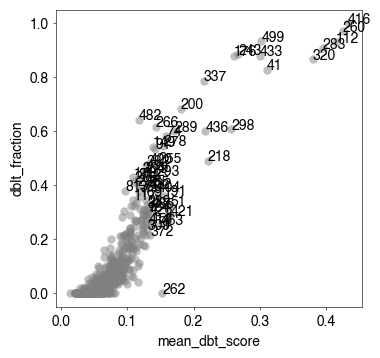

In [14]:
mpl.rcParams['figure.figsize'] = (8,8)
plt.rcParams.update({'font.size': 12})
mpl.rcParams['figure.dpi']= 200
a,fig,gs = rz.startfig(10,10)

lab1 = 'mean_dbt_score'
lab2 = 'dblt_fraction'

x = smr[lab1]
y = smr[lab2]

a.set_xlabel(lab1)
a.set_ylabel(lab2)

# print labels for the top n clusters with highest average dblt score
# and top n with highest fraction
upto=40

thetop = list(x.sort_values(ascending=False)[:upto].index)+\
         list(y.sort_values(ascending=False)[:upto].index)

for i,j,txt in zip(x,y,x.index):
    if txt in thetop:
        a.text(i,j,txt)

a.scatter(x,y,lw=0,c='0.5',alpha=0.5)
#plt.savefig('prec_pca_louv_60_doublets.png')

## Inspect interactively  
In the interactive SPRING explorer (in browser), inspect whether clusters with high scores. convincingly look like doublets

This includes taking into consideration:
- large clusters are not expected to be doublets
- is there unique gene expression in these clusters? Then they are not doublets.
- can you tell from which real populations these clusters where made?

In [16]:
doubcl = thetop


In [17]:
obs[label].isin(doubcl).sum()

1933

In [18]:
# add the cluster configuration used to obs
obs[label] = np.nan
obs.loc[obs.index,[label]] = cg0[label]

In [ ]:
# append a colotrack saying "removed_as_doublet"
obs['removed_as_dblt1'] = obs[label].isin(doubcl)
print(obs['removed_as_dblt1'].unique())
obs.head(2)

In [20]:
# Number of cells that will be removed

for i in obs.columns:
    if i.startswith('removed_as'):
        print(i, sum(obs[i]))

removed_as_dblt1 1933


## Add colotrack to spring

In [21]:
plot_name

'all_cells_w_dblts_spring'

In [22]:
len(cg0.keys())

12

In [23]:
# load current color dictionary
cg_ = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')

# color dictionary of dictionaries
cdd = {key:value['label_colors'] for key,value in cg_.items()}

cg = obs[[i for i in obs.columns if i.startswith(('removed_as'))]].astype(str).to_dict(orient='list')

# append categorical colortrack
srz.append_cell_groupings(project_dir+plot_name,cg,colordd=cdd)

## Save obs

In [24]:
# save the update obs dataframe
fname = 'backups/obs_info_dblt1_%dx%d_%s'%(obs.shape[0],obs.shape[1],rz.now())
print(fname)
rz.save_df(obs,fname)

backups/obs_info_dblt1_20021x15_231001_17h34


/opt/anaconda3/envs/sc/lib/python3.8/site-packages/numpy/lib/format.py:362: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
